In [21]:
#Load the modules
from glob import glob 
import numpy as np
import pandas as pd
import keras,cv2,os

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Input, \
    GlobalMaxPooling2D
from keras.layers import Conv2D, MaxPool2D
from keras.applications.nasnet import NASNetMobile

from tqdm import tqdm_notebook,trange
import matplotlib.pyplot as plt

import gc #garbage collection, we need to save all the RAM we can

# 2. The challenge and the data
The goal of this challenge is a binary classification task for images. Microscopic images of lymph node tissue with a resolution of 96x96 pixels are provided and we should provide a probability indicating if the images show metastatic cancer tissue in the 32x32 center region of the image.

About 220,000 labeled images are provided for training and about 57,000 make up the test set.

Let's start by loading the data and having a look at some of the images.

# 3. Loading the data

In [2]:
train_path = '../input/train/'
test_path = '../input/test/'

df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) # load the filenames
df['id'] = df.path.map(lambda x: x.split('/')[3].split(".")[0]) # keep only the file names in 'id'
labels = pd.read_csv('../input/train_labels.csv') 
df = df.merge(labels, on = "id") # merge labels and filepaths
df.head() 

,path,id,label
0,../input/train/92d05227eaa5198211a0402a7a7e840...,92d05227eaa5198211a0402a7a7e840c3e55c4cb,0
1,../input/train/1964c4fc2a7ababd9e7b657fa77b9cf...,1964c4fc2a7ababd9e7b657fa77b9cf26047b6fa,0
2,../input/train/250425c10dfb5260c0875904a304a1e...,250425c10dfb5260c0875904a304a1e3a335022e,0
3,../input/train/e2e51830174f815b383c68525966052...,e2e51830174f815b383c6852596605262c6153e8,0
4,../input/train/79797c9230db4af8493cab611bc0b32...,79797c9230db4af8493cab611bc0b327e07eda66,1


## Function for images loading

In [3]:
def load_data(N,df):
    """ This functions loads N images using the data df
    """
    # allocate a numpy array for the images (N, 96x96px, 3 channels, values 0 - 255)
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    y = np.squeeze(df.as_matrix(columns=['label']))[0:N]
    #read images one by one, tdqm notebook displays a progress bar
    for i, row in tqdm_notebook(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])
          
    return X,y

In [15]:
N = 20000 # for EDA we will use just a part of data to save kernal from crashing
X,y = load_data(N=N,df=df) 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


# 4. Exploratory Data Analysis
## Let's plot some example images with their assigned label (0 - no cancer cells, 1 - cancer cells):

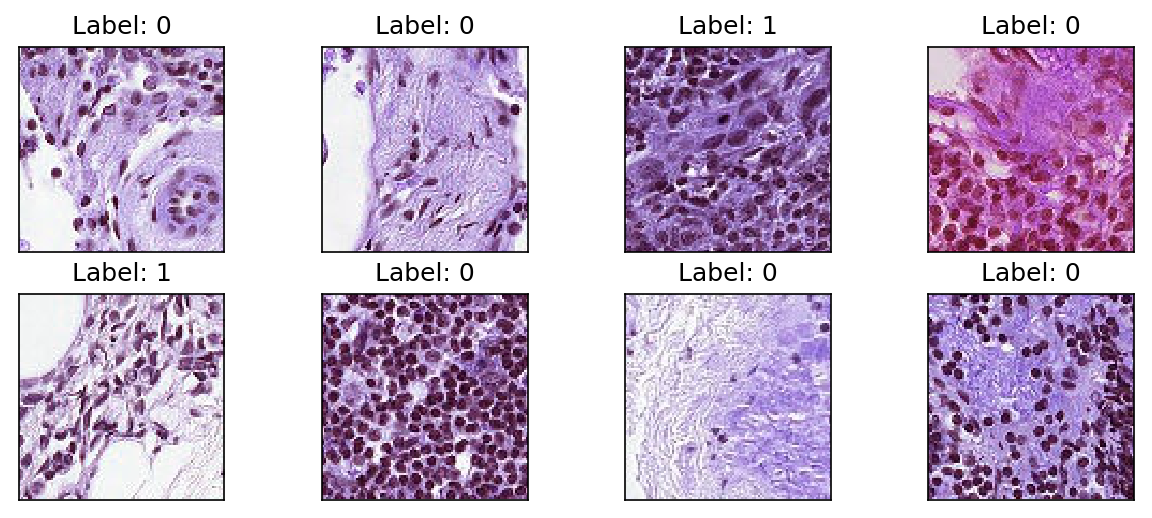

In [16]:
fig = plt.figure(figsize=(10, 4), dpi=150)
np.random.seed(42) #we can use the seed to get a different set of random images
for plotNr,idx in enumerate(np.random.randint(0,N,8)):
    ax = fig.add_subplot(2, 4, plotNr+1, xticks=[], yticks=[]) #add subplots
    plt.imshow(X[idx]) #plot image
    ax.set_title('Label: ' + str(y[idx])) #show the label corresponding to the image

Let's tell the truth, I don't see any differnce, so let's see deeper into distribution of RGB chanels and brightness

## Let's starting looking at the data distribution

We'll start by looking at how often the classes are represented. 

Text(0,0.5,'# of samples')

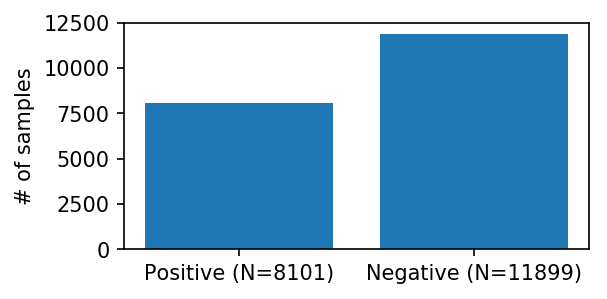

In [17]:
fig = plt.figure(figsize=(4, 2),dpi=150)
plt.bar([1,0], [(y==0).sum(), (y==1).sum()]); #plot a bar chart of the label frequency
plt.xticks([1,0],["Negative (N={})".format((y==0).sum()),"Positive (N={})".format((y==1).sum())]);
plt.ylabel("# of samples")

It is not 50/50, but classes are not very unbalanced

## Let's start looking at each class individually

In [18]:
positive_samples = X[y == 1]
negative_samples = X[y == 0]

Now, we will compare the distribution of pixel values for each color channel (RGB) individually and all channels together

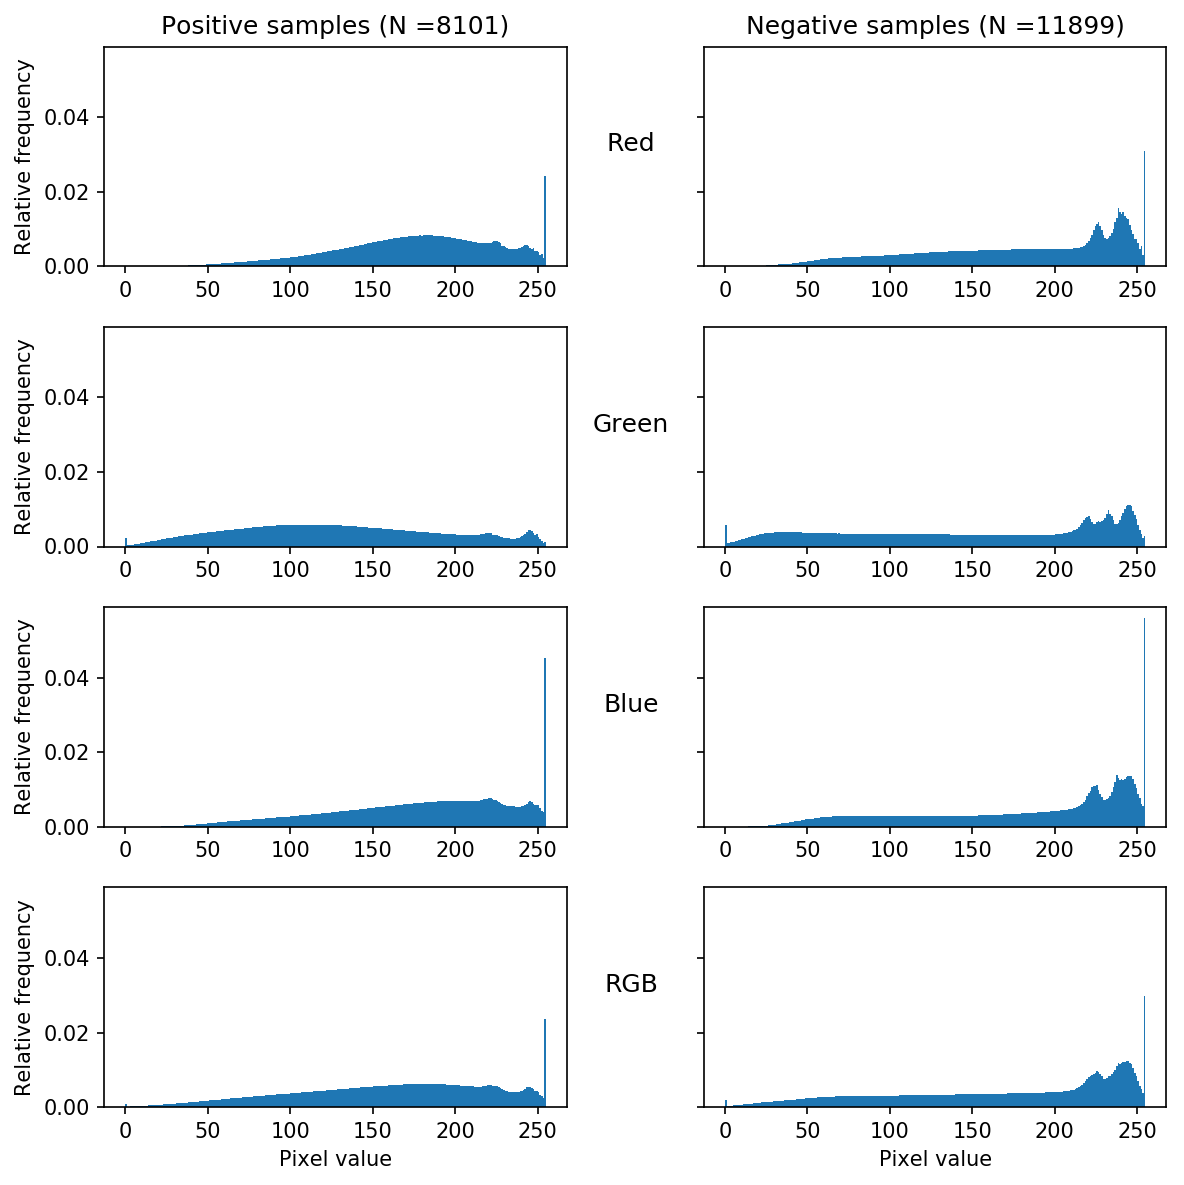

In [19]:
nr_of_bins = 256 #each possible pixel value will get a bin in the following histograms
fig,axs = plt.subplots(4,2,sharey=True,figsize=(8,8),dpi=150)

#RGB channels
axs[0,0].hist(positive_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
axs[0,1].hist(negative_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
axs[1,0].hist(positive_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
axs[1,1].hist(negative_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
axs[2,0].hist(positive_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)
axs[2,1].hist(negative_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)

#All channels
axs[3,0].hist(positive_samples.flatten(),bins=nr_of_bins,density=True)
axs[3,1].hist(negative_samples.flatten(),bins=nr_of_bins,density=True)

#Set image labels
axs[0,0].set_title("Positive samples (N =" + str(positive_samples.shape[0]) + ")");
axs[0,1].set_title("Negative samples (N =" + str(negative_samples.shape[0]) + ")");
axs[0,1].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12)
axs[1,1].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12)
axs[2,1].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12)
axs[3,1].set_ylabel("RGB",rotation='horizontal',labelpad=35,fontsize=12)
for i in range(4):
    axs[i,0].set_ylabel("Relative frequency")
axs[3,0].set_xlabel("Pixel value")
axs[3,1].set_xlabel("Pixel value")
fig.tight_layout()

Now, let's switch perspective and look at the distribution of mean image brightness.

Text(0,0.5,'Relative frequency')

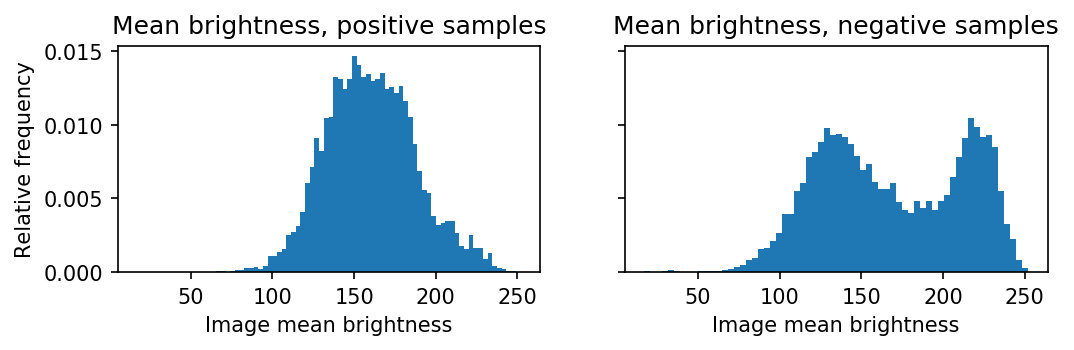

In [20]:
nr_of_bins = 64 #we use a bit fewer bins to get a smoother image
fig,axs = plt.subplots(1,2,sharey=True, sharex = True, figsize=(8,2),dpi=150)
axs[0].hist(np.mean(positive_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[1].hist(np.mean(negative_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[0].set_title("Mean brightness, positive samples");
axs[1].set_title("Mean brightness, negative samples");
axs[0].set_xlabel("Image mean brightness")
axs[1].set_xlabel("Image mean brightness")
axs[0].set_ylabel("Relative frequency")

We can spot pretty obvious differenes between the positive and negative samples. Negative samples have more bright pixels in all chanels. But green in negative is darker too.  The distribution of mean brightness for the positive samples looks almost like a normal distribution with peak at 150. The negative samples have two peaks and lean towards bright area. There are some outliers of very bright or dark regions, which could be artifacts, but they are not features of classes.

# Setup the model

For image augmentation I will use ImageDataGenerator class, also I will learn not on 32x32 center, but on 48x48, as it is giving better results.

In [ ]:
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(
    rescale=1./255 )

In [ ]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_path,
    x_col='id',
    y_col='label',
    has_ext=False,
    target_size=(96,96),
    class_mode='binary',
    batch_size=128,
    subset='training'
)
validation_gen = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_path,
    x_col='id',
    y_col='label',
    has_ext=False,
    target_size=(96,96),
    class_mode='binary',
    batch_size=128,
    subset='validation'
    )

Let's declare our neural network architecture now. Here is some simple archetecture, I was trying to add another block without pooling, but got errors, so I use this one. As it was my first CNN, that was the most clear for understanding model.

In [ ]:
#just some network parameters, see above link regarding the layers for details
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

#dropout is used for regularization here with a probability of 0.3 for conv layers, 0.5 for the dense layer at the end
dropout_conv = 0.3
dropout_dense = 0.5

#initialize the model
model = Sequential()

#now add layers to it

#conv block 1
model.add(Conv2D(first_filters, kernel_size, activation='relu', input_shape=(96,96,3)))
model.add(Conv2D(first_filters, kernel_size, activation='relu'))
model.add(Conv2D(first_filters, kernel_size, activation='relu'))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

#conv block 2
model.add(Conv2D(second_filters, kernel_size, activation='relu'))
model.add(Conv2D(second_filters, kernel_size, activation='relu'))
model.add(Conv2D(second_filters, kernel_size, activation='relu'))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

#conv block 3
model.add(Conv2D(third_filters, kernel_size, activation='relu'))
model.add(Conv2D(third_filters, kernel_size, activation='relu'))
model.add(Conv2D(third_filters, kernel_size, activation='relu'))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

#a fully connected (also called dense) layer at the end
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_dense))

#finally convert to values of 0 to 1 using the sigmoid activation function
model.add(Dense(1, activation = "sigmoid"))
model.summary()

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

# 6. Train and validate the model

In [ ]:
step_train = train_gen.n//train_gen.batch_size
step_validation = validation_gen.n//validation_gen.batch_size

In [ ]:
step_validation

In [ ]:
model.fit_generator(
                train_gen,
                steps_per_epoch=step_train,
                epochs=15,
                validation_data=validation_gen,
                validation_steps=step_validation)

# 7. Create a submission

In [ ]:
test_files = glob(os.path.join(test_path,'*.tif')) 
submission = pd.DataFrame()
file_batch = 5000 
max_idx = len(test_files) 
for idx in range(0, max_idx, file_batch): #iterate over test image batches
    print("Indexes: %i - %i"%(idx, idx+file_batch))
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]}) 
    test_df['id'] = test_df.path.map(lambda x: x.split('/')[3].split(".")[0]) 
    test_df['image'] = test_df['path'].map(cv2.imread) 
    K_test = np.stack(test_df["image"].values) 
    predictions = model.predict(K_test,verbose = 1) 
    test_df['label'] = predictions 
    submission = pd.concat([submission, test_df[["id", "label"]]])

In [ ]:
submission.to_csv("submission.csv", index = False, header = True) #create the submission file

# 8. Another model

As I was searching for types of networks, exept of simple CNN I saw more complicated NN as NASNet or ResNet. And keras has them! (That was really pleasant surprize for me). So I decided to try to make something with NASNet. In some examples that I saw they use Model class API, so I decided to use it, for lerning this method of building model

In [ ]:
inputs = Input((96, 96, 3))
base_model = NASNetMobile(include_top=False, input_shape=(96, 96, 3))
out = base_model(inputs)
out = GlobalMaxPooling2D()(out)
out = Dropout(0.5)(out)
out = Dense(1, activation="sigmoid")(out)
model = Model(inputs, out)
model.compile(optimizer=Adam(0.0001), loss=binary_crossentropy, metrics=['acc'])
model.summary()

model.fit_generator(
    train_gen,
    validation_data=validation_gen,
    epochs=2, verbose=1,
    callbacks=[checkpoint],
    steps_per_epoch=train_gen.n // train_gen.batch_size,
    validation_steps=validation_gen.n // validation_gen.batch_size)

By the end I got result of 0.9113 with my first model
![title](1.png)